# Predicted Orbit Files

Predicted Orbit Files are generated from FOS for the three Swarm spacecrafts.

They are available on Swarm FTP at `/Auxiliary/Sat_x/MPLxORBPRE` for `mission` users.

## Parse predicted orbit file from ZIP archive

In [1]:
from pathlib import Path
from xml.etree import ElementTree
from zipfile import ZipFile

import pandas as pd
from dateutil.parser import parse
import numpy as np
from matplotlib import pyplot
from scipy import interpolate

In [2]:
file = Path('SW_OPER_MPLAORBPRE_20201126T000000_20201231T000000_2560.ZIP').resolve()

with ZipFile(file) as zf:
    et = ElementTree.parse(zf.open(file.with_suffix('.EEF').name))

# parse orbit state vectors
ns = {'': 'http://eop-cfi.esa.int/CFI'}
osvs = [
    {
        'TAI': parse(osv.findtext('TAI', namespaces=ns)[4:]),
        'UTC': parse(osv.findtext('UTC', namespaces=ns)[4:]),
        'UT1': parse(osv.findtext('UT1', namespaces=ns)[4:]),
        'Absolute_Orbit': int(osv.findtext('Absolute_Orbit', namespaces=ns)),
        'X': float(osv.findtext('X', namespaces=ns)),
        'Y': float(osv.findtext('Y', namespaces=ns)),
        'Z': float(osv.findtext('Z', namespaces=ns)),
        'VX': float(osv.findtext('VX', namespaces=ns)),
        'VY': float(osv.findtext('VY', namespaces=ns)),
        'VZ': float(osv.findtext('VZ', namespaces=ns))
    }
    for osv in et.iterfind('./Data_Block/List_of_OSVs/OSV', ns)
]

osvs_df = pd.DataFrame(osvs)
osvs_df.head()

,TAI,UTC,UT1,Absolute_Orbit,X,Y,Z,VX,VY,VZ
0,2020-11-26 00:33:15.566936,2020-11-26 00:32:38.566936,2020-11-26 00:32:38.387528,39418,6810128.732,-200683.127,4296.648,-20.191900,-144.666866,7642.501918
1,2020-11-26 02:06:31.920126,2020-11-26 02:05:54.920126,2020-11-26 02:05:54.740707,39419,6170133.040,-2889349.329,4298.438,-76.051564,-124.783002,7642.425501
2,2020-11-26 03:39:48.230336,2020-11-26 03:39:11.230336,2020-11-26 03:39:11.050905,39420,4514786.355,-5102725.570,4301.718,-119.317375,-84.322037,7642.211325
3,2020-11-26 05:13:04.617377,2020-11-26 05:12:27.617377,2020-11-26 05:12:27.437929,39421,2116381.512,-6476365.304,4306.367,-142.625842,-29.815494,7642.146300
4,2020-11-26 06:46:21.128812,2020-11-26 06:45:44.128812,2020-11-26 06:45:43.949337,39422,-630378.865,-6784111.768,4312.516,-142.563045,29.327468,7642.197483


In [3]:
anxs = osvs_df[['UTC', 'Absolute_Orbit']].set_index('UTC')['Absolute_Orbit']
anxs.index.name = None
anxs

2020-11-26 00:32:38.566936    39418
2020-11-26 02:05:54.920126    39419
2020-11-26 03:39:11.230336    39420
2020-11-26 05:12:27.617377    39421
2020-11-26 06:45:44.128812    39422
                              ...  
2020-12-30 17:45:13.312885    39954
2020-12-30 19:18:29.316025    39955
2020-12-30 20:51:45.269973    39956
2020-12-30 22:25:01.204554    39957
2020-12-30 23:58:17.099850    39958
Name: Absolute_Orbit, Length: 541, dtype: int64

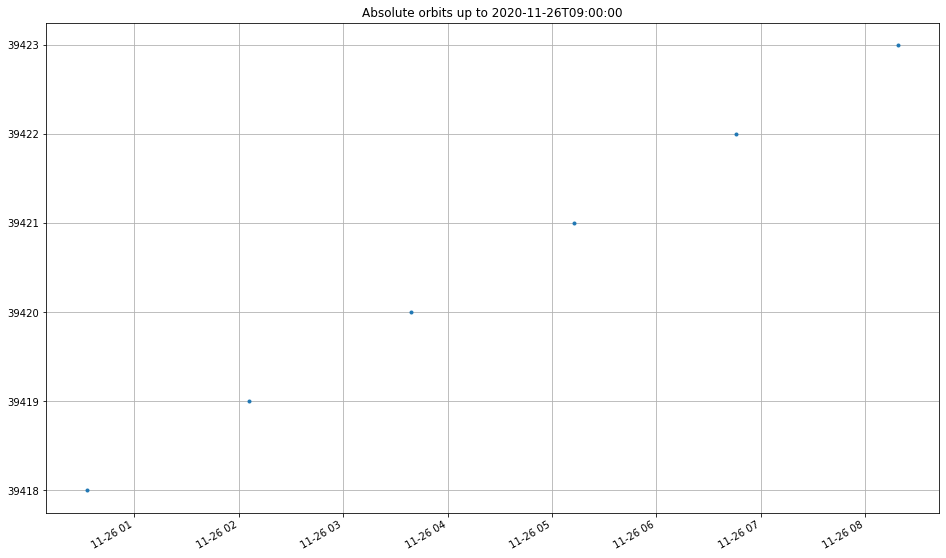

In [4]:
end = '2020-11-26T09:00:00'
anxs.loc[:end].plot(figsize=(16, 10), style='.', grid=True, title=f"Absolute orbits up to {end}")
pyplot.show()

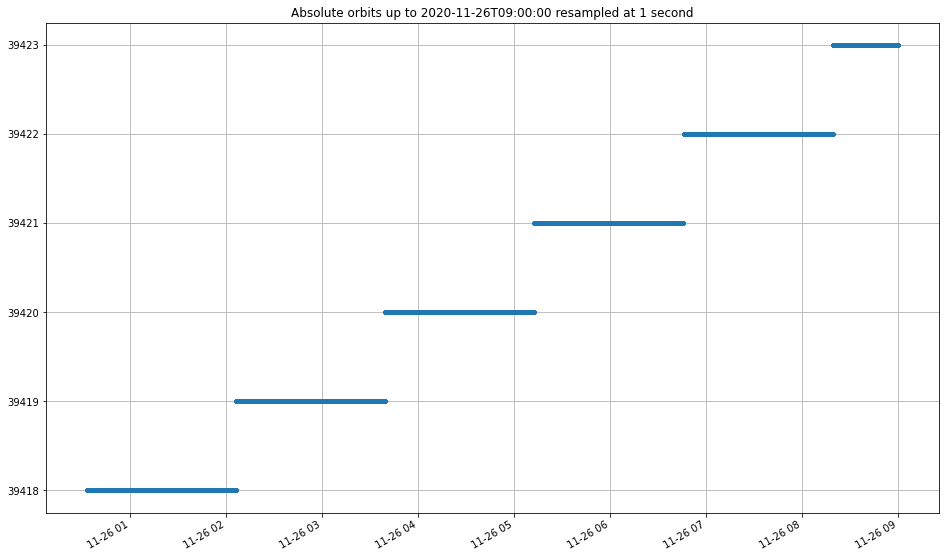

In [5]:
end = '2020-11-26T09:00:00'
anxs.asfreq('S', method='pad').loc[:end].plot(
    figsize=(16, 10), style='.', grid=True,
    title=f"Absolute orbits up to {end} resampled at 1 second"
)
pyplot.show()